Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.distributions import Categorical
from collections import Counter
from scipy.stats import skew, kurtosis
import seaborn as sns
import gymnasium
from gymnasium import spaces

import pandas as pd

#### DATA

FUNCTIONS

In [2]:
def gbm_simulator_with_deltas(S0, mu, sigma, n_days=12, n_sequences=50000, annual_trading_days=252):
    sequences = []
    delta_sequences = []
    
    for i in range(n_sequences):
        # Time horizon and time step
        T = n_days / annual_trading_days
        dt = T / n_days
        
        # Time vector
        t = np.linspace(0, T, n_days)
        
        # Generate Wiener process increments
        W_increments = np.random.normal(0, np.sqrt(dt), n_days)
        W = np.cumsum(W_increments)  # Cumulative Wiener process
        
        # Geometric Brownian Motion (GBM) process
        S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
        
        # Calculate price deltas (differences between consecutive prices)
        Delta_GBM = np.diff(S)  # Price deltas
        
        sequences.append(S)
        delta_sequences.append(Delta_GBM)
    
    return np.array(sequences), np.array(delta_sequences)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, seq_length = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)

    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    # Split the data based on 60/20/20 ratio
    train_size = int(0.6 * n_sequences)
    val_size = int(0.2 * n_sequences)
    
    train_data = tokenized_sequences[:train_size]  # First 60% of sequences for training
    val_data = tokenized_sequences[train_size:train_size + val_size]  # Next 20% for validation
    test_data = tokenized_sequences[train_size + val_size:]  # Remaining 20% for testing

    print('Number of Tokens:', num_bins)
    print('Training Data Shape:', train_data.shape)
    print('Validation Data Shape:', val_data.shape)
    print('Test Data Shape:', test_data.shape)

    return train_data, val_data, test_data, num_bins

def calculate_entropy(sequence):
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    # Probability distribution of tokens
    probabilities = {token: count / total_tokens for token, count in token_counts.items()}
    # Calculate the Shannon entropy
    entropy = -sum(p * np.log(p) for p in probabilities.values())
    return entropy

def kl_divergence(real_sequence, fake_sequence):

    # Frequency of each token in the real and fake sequences
    real_counts = Counter(real_sequence)
    fake_counts = Counter(fake_sequence)
    
    # Total number of tokens in each sequence
    total_real_tokens = len(real_sequence)
    total_fake_tokens = len(fake_sequence)
    
    # Probability distribution of tokens
    real_probabilities = {token: count / total_real_tokens for token, count in real_counts.items()}
    fake_probabilities = {token: count / total_fake_tokens for token, count in fake_counts.items()}
    
    # KL divergence
    kl_divergence = 0
    for token, p_real in real_probabilities.items():
        p_fake = fake_probabilities.get(token, 1e-10)  # Small value to avoid division by zero
        kl_divergence += p_real * np.log2(p_real / p_fake)
    
    return kl_divergence

def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
        max_vals.append(np.max(traj))
        min_vals.append(np.min(traj))
    
    return means, variances, std_devs, skewness, kurtos, max_vals, min_vals



SETTINGS

In [3]:
S0 = 100                # Initial stock price
mu = 0.1                # Annual drift
sigma = 0.2             # Volatility
n_days = 12             # Sequence length (52 days)
n_sequences = 50000     # Number of sequences to simulate


Geometric Brownian Motion Simulator

$S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t\right)$

$dS_t = \mu S_tdt + \sigma S_tdW_t \\$


In [4]:
Price_GBM, Delta_GBM = gbm_simulator_with_deltas(S0, mu, sigma, n_days=n_days, n_sequences=n_sequences)

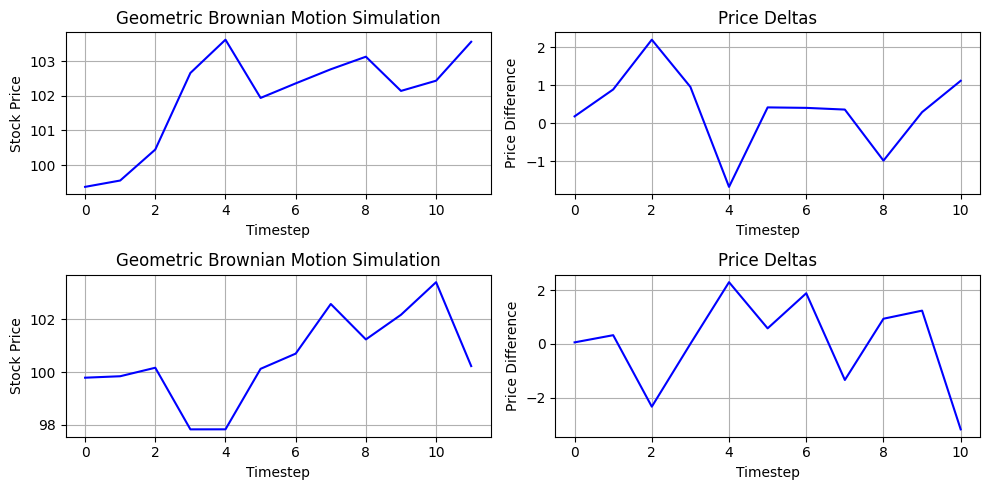

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0,0].plot(Price_GBM[0], color='blue')
axs[0,0].set_title('Geometric Brownian Motion Simulation')
axs[0,0].set_xlabel('Timestep')
axs[0,0].set_ylabel('Stock Price')
axs[0,0].grid('True')

axs[0,1].plot(Delta_GBM[0], color='blue')
axs[0,1].set_title('Price Deltas')
axs[0,1].set_xlabel('Timestep')
axs[0,1].set_ylabel('Price Difference')
axs[0,1].grid('True')

axs[1,0].plot(Price_GBM[5], color='blue')
axs[1,0].set_title('Geometric Brownian Motion Simulation')
axs[1,0].set_xlabel('Timestep')
axs[1,0].set_ylabel('Stock Price')
axs[1,0].grid('True')

axs[1,1].plot(Delta_GBM[5], color='blue')
axs[1,1].set_title('Price Deltas')
axs[1,1].set_xlabel('Timestep')
axs[1,1].set_ylabel('Price Difference')
axs[1,1].grid('True')
plt.tight_layout()
plt.show()

BIN WIDTH

In [6]:
bin_width = 0.3
print('Standard Deviation of Price Deltas:', np.round(np.std(Delta_GBM.flatten()),3))
print('BIN WIDTH: ', bin_width)

Standard Deviation of Price Deltas: 1.263
BIN WIDTH:  0.3


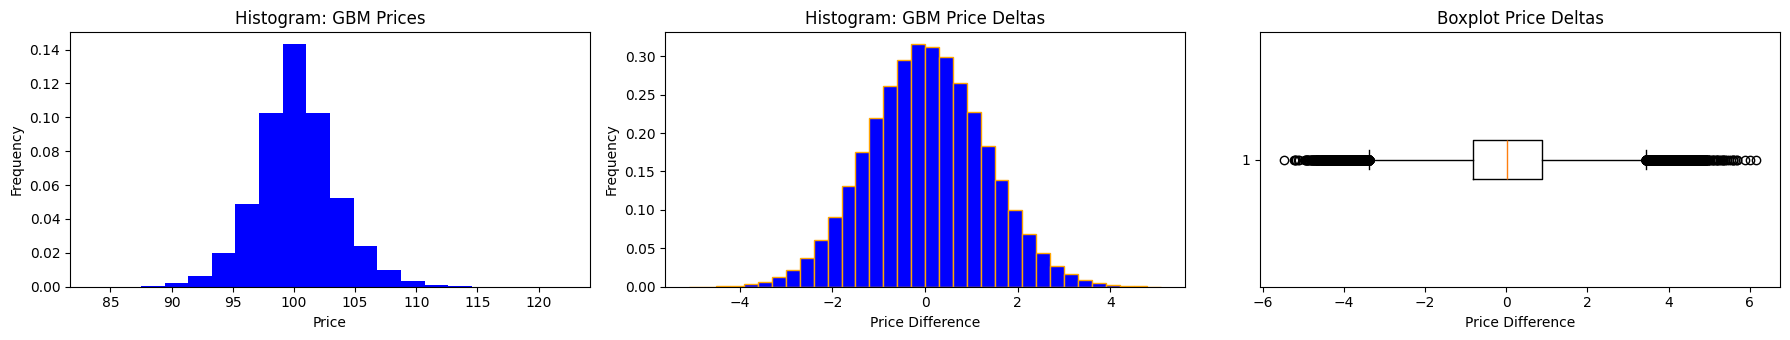

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

# Histogram: GBM Prices
axs[0].hist(Price_GBM.flatten(), bins=20, color='blue', density=True)
axs[0].set_title('Histogram: GBM Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

bins = np.arange(-5.1, 5.1 + bin_width, bin_width)

# Histogram: GBM Price Deltas
axs[1].hist(Delta_GBM.flatten(), 
            bins=bins, 
            edgecolor='orange', color='blue', density=True)
axs[1].set_title('Histogram: GBM Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

# Boxplot Price Deltas
axs[2].boxplot(Delta_GBM.flatten(), vert=False)
axs[2].set_title('Boxplot Price Deltas')
axs[2].set_xlabel('Price Difference')
plt.tight_layout()
plt.show()


In [8]:
train_data, val_data, test_data, token_size = tokenize_deltas(Delta_GBM, bin_start=-5.1, bin_stop=5.1, bin_width=bin_width)

Number of Tokens: 34
Training Data Shape: (30000, 11)
Validation Data Shape: (10000, 11)
Test Data Shape: (10000, 11)


In [9]:
class MLPModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Fully connected hidden layers
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)     # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)        # Second hidden layer
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)   # Output layer

    def forward(self, x):
        # Embedding Layer: Shape (batch_size, sequence_length, embedding_dim)
        embedded = self.embedding(x)
        # Flatten: [batch_size * seq_len, embedding_dim]
        # Flatten the input: Combine sequence and embedding dimensions for MLP processing
        embedded = embedded.view(embedded.size(0) * embedded.size(1), -1) 
        # Fully connected layers with ACTIVATION FUNCTION
        out = F.relu(self.fc1(embedded))
        out = F.relu(self.fc2(out))
        # Output layer: [batch_size * seq_len, output_dim]
        logits = self.fc_out(out)
        # Reshape back to (batch_size, sequence_length, output_dim)
        logits = logits.view(x.size(0), x.size(1), -1)
        return logits

#### Train setting:

| Train set:                           |     30'000  Sequences        |
| ------------------------------------ | ---------------------------- |
| **Sequence Length:**                 | **50**                       |             
| **Batch size:**                      | **512**                      |


In [10]:
vocab_size = token_size                         # Example vocab size (number of tokens)
embedding_dim = 32                              # Embedding size
hidden_dim = 128                                # Hidden Dimension
output_dim = vocab_size                         # Output Dimension
sequence_lengthseq_len = len(train_data[0])     # Length of your tokenized sequences

batch_size = 512                                # Batch Size
learning_rate = 0.001                           # Learning Rate
num_epochs = 10                                 # Number of epochs to train

In [12]:
model_supervised = MLPModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_data_supervised = torch.tensor(train_data, dtype=torch.long)

val_supervised_inputs = torch.tensor(val_data[:, :-1], dtype=torch.long)
val_supervised_targets = torch.tensor(val_data[:, 1:], dtype=torch.long)
val_supervised_targets = val_supervised_targets.reshape(-1)


train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):

    temp_train_loss = []
    temp_val_loss = []
    
    ## ============
    ## TRAINING
    ## ============
    
    # Shuffle the data at the beginning of the epoch
    indices = np.arange(len(train_data_supervised))
    np.random.shuffle(indices)
    
    for batch_idx in range(0, len(train_data_supervised), batch_size):
        
        model_supervised.train()
        batch_indices = indices[batch_idx:batch_idx + batch_size]
        batch = train_data_supervised[batch_indices]

        inputs = batch[:, :-1]
        targets = batch[:, 1:]

        logits = model_supervised(inputs)
        logits = logits.view(-1, vocab_size)    # Flatten logits: (batch_size * seq_len, num_bins)
        targets = targets.reshape(-1)           # Flatten targets: (batch_size * seq_len)

        loss = criterion(logits, targets)
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the model parameters

        train_losses.append(loss.item())
        temp_train_loss.append(loss.item())

        ## ============
        ## VALIDATION
        ## ============

        model_supervised.eval()

        with torch.no_grad():

            logits = model_supervised(val_supervised_inputs)
            logits = logits.view(-1, vocab_size)
            loss = criterion(logits, val_supervised_targets)
            val_losses.append(loss.item())
            temp_val_loss.append(loss.item())
        
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            torch.save(model_supervised.state_dict(), 'supervised_weights.pth')

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_train_loss):.4f} - Val Loss: {np.mean(temp_val_loss):.4f}")


Epoch 1/10 - Train Loss: 2.9873 - Val Loss: 2.9728
Epoch 2/10 - Train Loss: 2.8595 - Val Loss: 2.8582
Epoch 3/10 - Train Loss: 2.8584 - Val Loss: 2.8576
Epoch 4/10 - Train Loss: 2.8584 - Val Loss: 2.8577
Epoch 5/10 - Train Loss: 2.8586 - Val Loss: 2.8577
Epoch 6/10 - Train Loss: 2.8585 - Val Loss: 2.8577
Epoch 7/10 - Train Loss: 2.8582 - Val Loss: 2.8575
Epoch 8/10 - Train Loss: 2.8580 - Val Loss: 2.8573
Epoch 9/10 - Train Loss: 2.8580 - Val Loss: 2.8575
Epoch 10/10 - Train Loss: 2.8582 - Val Loss: 2.8578


Entropy of Validation Data: 2.855


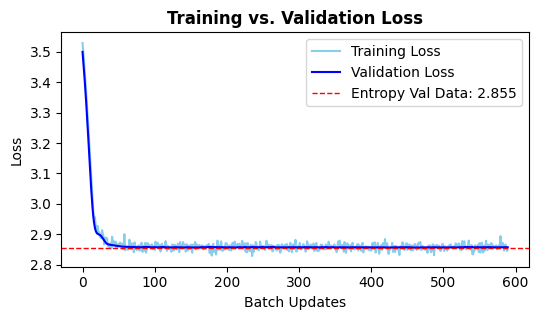

In [13]:
# Entropy calculation and display
entropy_val = round(calculate_entropy(val_data.flatten()), 3)
print('Entropy of Validation Data:', entropy_val)

# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_losses, label='Training Loss', color='skyblue', linewidth=1.5)
plt.plot(val_losses, label='Validation Loss', color='blue', linewidth=1.5)
plt.axhline(entropy_val, color='red', linestyle='--', linewidth=1, label=f'Entropy Val Data: {entropy_val}')
plt.title('Training vs. Validation Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

##### Inference on Test Data

In [14]:
inference_model = MLPModel(vocab_size, embedding_dim, hidden_dim, output_dim)
inference_model.load_state_dict(torch.load('supervised_weights.pth', weights_only=False))

test_data_inference = torch.tensor(test_data, dtype=torch.long)

test_losses = []
trajectories = []

inference_model.eval()

with torch.no_grad():
    
    for sequence in test_data_inference:

        token_loss = 0

        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]
        
        for i in range(1, len(sequence)):

            input = sim_trajectory[-1].reshape(-1, 1, 1)

            logits = inference_model(input)
            
            probs = F.softmax(logits, dim=-1).squeeze()
            predicted_token = torch.multinomial(probs, num_samples=1).squeeze()
            
            sim_trajectory.append(predicted_token)

            # Loss
            true_token = sequence[i].unsqueeze(-1)
            loss = criterion(logits.squeeze(1), true_token)
            token_loss += loss.item()

        test_losses.append(token_loss/len(sequence))
        trajectories.append(sim_trajectory)



KL Divergence

$D_{KL}(P_{\text{real}} \parallel P_{\text{fake}}) = \sum_{i} p_{\text{real}}(x_i) \log \left( \frac{p_{\text{real}}(x_i)}{p_{\text{fake}}(x_i)} \right)$

In [15]:
kl_div = round(kl_divergence(np.array(test_data_inference).flatten(), np.array(trajectories).flatten()),5)
print("KL Divergence between Real and Fake Sequences (in bits):", kl_div)

KL Divergence between Real and Fake Sequences (in bits): 0.00112


SUMMARY STATISTICS

In [16]:
# Statistics for real and simulated trajectories
real_means, real_variances, real_std_devs, real_skew, real_kurtosis, real_max_vals, real_min_vals = calculate_statistics(test_data)
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis, sim_max_vals, sim_min_vals = calculate_statistics(trajectories)

bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_width_mean = 0.5
bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)

bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_width_var = 2
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)

bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))
bin_width_skew = 0.2
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

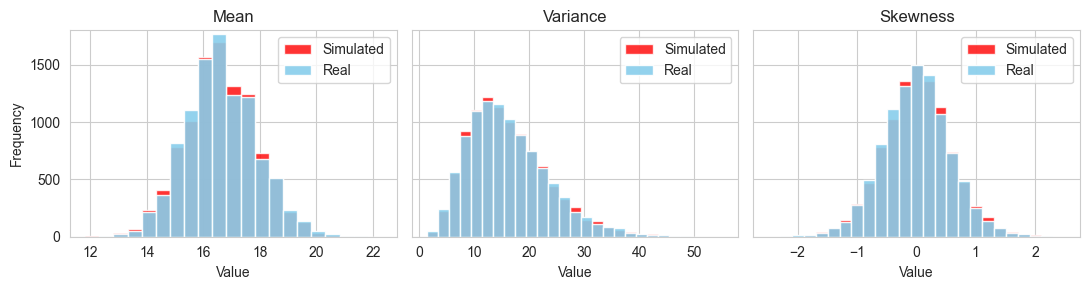

In [17]:
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

fig, axs = plt.subplots(1, 3, figsize=(11, 3))

# Plot 1: Mean Distribution
axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
axs[0].legend(loc='upper right')
axs[0].set_title('Mean')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].set_ylim(0,1800)

# Plot 1: Variance Distribution
axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
axs[1].legend(loc='upper right')
axs[1].set_title('Variance')
axs[1].set_xlabel('Value')
axs[1].set_ylim(0,1800)
axs[1].tick_params(labelleft=False)

# Plot 2: Skewness Distribution
axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
axs[2].legend(loc='upper right')
axs[2].set_title('Skewness')
axs[2].set_xlabel('Value')
axs[2].set_ylim(0,1800)
axs[2].tick_params(labelleft=False)
plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
plt.tight_layout()
plt.show()

TRAJECTORY COMPARISON

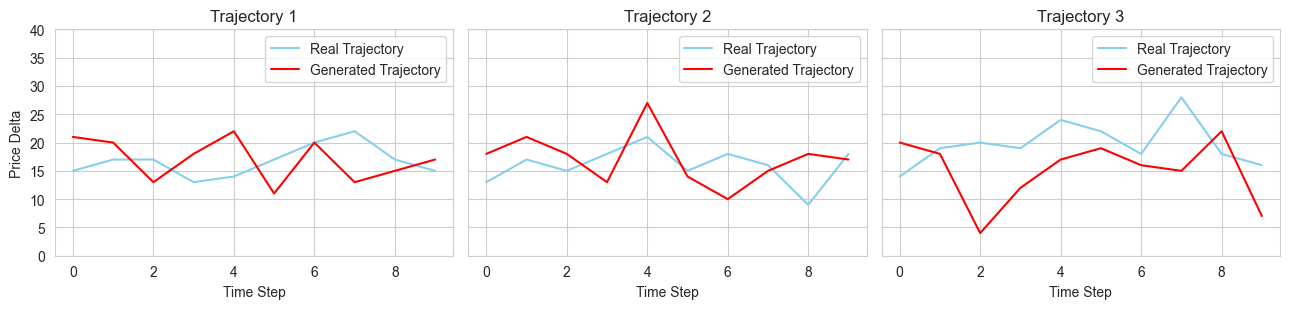

In [19]:
# Set Seaborn style with custom grid transparency
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})  # Adjust grid transparency to 0.3

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
axes = axes.flatten()

# Plot the real and simulated trajectories
for i in range(3):
    axes[i].plot(test_data[i][1:], label='Real Trajectory', color='skyblue', linewidth=1.5)
    axes[i].plot(trajectories[i][1:], label='Generated Trajectory', color='red', linewidth=1.5)
    axes[i].legend(loc='best')
    axes[i].set_title(f'Trajectory {i+1}')
    axes[i].set_ylim(0, 40)
    axes[i].set_xlabel('Time Step')
    
    if i == 0:  # Only set y-axis label on the first plot
        axes[i].set_ylabel('Price Delta')
    else:
        axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
plt.show()

##### GAIL

**Advantage Function**

$\hat{A}_t = \delta_t + (\gamma \lambda) \delta_{t+1} + (\gamma \lambda)^2 \delta_{t+2} + \cdots$

$ A_t = \delta_{t} + (\gamma\lambda)  A_{t+1}$

$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_{t})$

$ A_t = r_t + \gamma V(s_{t+1}) - V(s_{t}) + (\gamma\lambda)  A_{t+1}$

where:

- $\gamma$ is the discount factor.
- $\lambda$ parameter that controls the bias-variance trade-off.
- $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ is the TD error.



In [11]:
class FeedForwardNN(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(FeedForwardNN, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Fully connected hidden layers
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)     # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)        # Second hidden layer
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)     # Output layer

    def forward(self, x):
        # Embedding Layer: Shape (batch_size, sequence_length, embedding_dim)
        embedded = self.embedding(x)
        # Flatten: [batch_size * seq_len, embedding_dim]
        # Flatten the input: Combine sequence and embedding dimensions for MLP processing
        embedded = embedded.view(embedded.size(0) * embedded.size(1), -1)
        # Fully connected layers
        out = F.relu(self.fc1(embedded))
        out = F.relu(self.fc2(out))
        # Output layer: [batch_size * seq_len, output_dim]
        logits = self.fc_out(out)
        # Reshape back to (batch_size, sequence_length, output_dim)
        logits = logits.view(x.size(0), x.size(1), -1)
        return logits

In [12]:
class GAIL_env(gymnasium.Env):
    
    def __init__(self, train_data, val_data, test_data, training, token_size):
        
        super(GAIL_env, self).__init__()

        self.token_size = token_size

        # Data
        self.train_data = train_data.astype(int)
        self.val_data = val_data.astype(int)
        self.test_data = test_data.astype(int)

        # RESET
        self.rollout_batch = []

        # Spaces
        self.action_space = spaces.Discrete(self.token_size)        # Action Space
        self.observation_space = spaces.Discrete(self.token_size)   # State Space

    def step(self, action):

        assert self.action_space.contains(action.item()), "Invalid Action"

        ### ===============
        ###     REWARD
        ### =============== 

        if 20 <= action.item() <= 30:
            reward = 1
        else:
            reward = 0

        ### ===============
        ###     REWARD
        ### ===============

        next_state = action

        # state, reward, done, truncated, info
        return next_state, reward, False, False, {}

    
    def reset(self, training, batch_size, seed=None):
        
        if seed is not None:
            np.random.seed(seed)
        
        self.rollout_batch = []

        if training:
            batch_indices = np.random.choice(len(self.train_data), size = batch_size, replace=False)
            self.rollout_batch = self.train_data[batch_indices]
        
        # IMPLEMENT TEST!
        else:
            pass

In [76]:
class customPPO:
    
    def __init__(self,
                 env,
                 embedding_dim,
                 hidden_dim,
                 gamma,
                 gae_lambda,
                 clip_range,
                 learning_rate,
                 batch_size,
                 n_updates) -> None:
        
        self.env = env
        
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_range = clip_range
        self.lr = learning_rate
        self.batch_size = batch_size
        self.n_updates = n_updates
        
        self.obs_dim = self.env.token_size
        self.act_dim = self.env.token_size

        self.actor = FeedForwardNN(self.obs_dim, embedding_dim, hidden_dim, self.act_dim)
        self.critic = FeedForwardNN(self.obs_dim, embedding_dim, hidden_dim, 1)

        self.actor_optim = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=self.lr)
        
        self.rollout_buffer = {
            'observations': [],  # Partial sequences
            'actions': [],       # Tokens selected by the agent
            'log_probs': [],     # Log-probs of selected tokens
            'values': [],        # Value estimates from the critic
            'rewards': [],       # Reward for each token
            'advantages': [],    # Advantage estimates
            'returns': []        # Discounted returns
            }
        
        self.pg_losses, self.value_losses, self.entropy_losses, self.rewards, self.kl_div = [], [], [], [], []

        self.update_counter = 0

        ## ORTHOGONAL INITALIZATION?

    def collect_rollout(self):

        self.actor.eval()
        self.critic.eval()
        
        # Clear the rollout buffer
        for key in self.rollout_buffer:
            self.rollout_buffer[key].clear()
        
        self.env.reset(training=True, batch_size=self.batch_size)

        for sequence in self.env.rollout_batch:

            rollout_obs = []
            rollout_acts = []
            rollout_log_prob = []
            rollout_val = []
            rollout_rew = []

            obs = torch.tensor(sequence[0], dtype=torch.long)

            with torch.no_grad():

                for _ in range(1, len(sequence)):

                    rollout_obs.append(obs.item())

                    action, log_prob, value = self.forward(obs)
                    obs, reward, _, _, _ = self.env.step(action)
            
                    rollout_acts.append(action.item())
                    rollout_log_prob.append(log_prob.item())
                    rollout_val.append(value.item())
                    rollout_rew.append(reward)
    
            # Advantage estimator
            rollout_adv, rollout_ret = self.advantage_and_return(rewards=rollout_rew, values=rollout_val)

            self.rollout_buffer['observations'].append(rollout_obs)
            self.rollout_buffer['actions'].append(rollout_acts)
            self.rollout_buffer['log_probs'].append(rollout_log_prob)
            self.rollout_buffer['values'].append(rollout_val)
            self.rollout_buffer['rewards'].append(rollout_rew)
            self.rollout_buffer['advantages'].append(rollout_adv)
            self.rollout_buffer['returns'].append(rollout_ret)

    def train(self):
        
        self.actor.train()
        self.critic.train()

        #### Update Optimizer Learning Rate HERE
        #### Clip range for value?

        # Convert the Rollout to Tensor
        batch_sequences = self.rollout_buffer.copy()
        
        for key in batch_sequences:
            if key in ['observations', 'actions']:
                batch_sequences[key] = torch.tensor(np.array(batch_sequences[key]), dtype=torch.long)
            else:
                batch_sequences[key] = torch.tensor(np.array(batch_sequences[key]), dtype=torch.float32)

        for epoch in range(self.n_updates):

            pg_loss_list, value_loss_list, entropy_loss_list, reward_list = [], [], [], []
            #### Approx kl divergence for early stopping?

            for obs, acts, log_probs_rollout, advantages, returns, values_rollout, rewards in zip(
                batch_sequences['observations'],
                batch_sequences['actions'],
                batch_sequences['log_probs'],
                batch_sequences['advantages'],
                batch_sequences['returns'],
                batch_sequences['values'],
                batch_sequences['rewards']):

                log_probs, values, entropy = self.evaluate_actions(observations=obs, actions=acts)

                ratio = torch.exp(log_probs - log_probs_rollout)

                # POLICY LOSS
                policy_loss_1 = advantages * ratio
                policy_loss_2 = advantages * torch.clamp(ratio, 1 - self.clip_range, 1 + self.clip_range)
                policy_loss  = -torch.mean(torch.min(policy_loss_1, policy_loss_2))

                # Clip Fraction for logging
                # Clip for value
                

                # VALUE LOSS
                value_loss = nn.MSELoss()(returns, values)
                
                # EMTROPY LOSS      
                entropy_loss = -torch.mean(entropy)

                # REWARD
                reward_sequence = torch.sum(rewards)
                
                pg_loss_list.append(policy_loss)
                value_loss_list.append(value_loss)
                entropy_loss_list.append(entropy_loss)
                reward_list.append(reward_sequence)

                ## EARLY STOPPING APPROX KL DIV
            
            ##===================###
            # Actor Critic Training
            ###==================###

            policy_loss_batch = torch.mean(torch.stack(pg_loss_list))
            value_loss_batch = torch.mean(torch.stack(value_loss_list))
            entropy_loss_batch = torch.mean(torch.stack(entropy_loss_list))
            reward_batch = torch.mean(torch.stack(reward_list))

            # Actor Optimization
            self.actor_optim.zero_grad()
            #policy_loss_batch.backward(retain_graph=True)
            policy_loss_batch.backward()
            self.actor_optim.step()

            # Critic Optimization
            self.critic_optim.zero_grad()
            value_loss_batch.backward()
            self.critic_optim.step()

            self.pg_losses.append(policy_loss_batch.item())
            self.value_losses.append(value_loss_batch.item())
            self.entropy_losses.append(entropy_loss_batch.item())
            self.rewards.append(reward_batch.item())

            ##===================###
            # Actor Critic Training
            ###==================###

            # KL-Divergence
            real_seq = np.array(self.env.rollout_batch[:,1:]).flatten()
            sim_seq = np.array(self.rollout_buffer['actions']).flatten()
            kl_div_batch = self.kl_divergence(real_sequence=real_seq, fake_sequence=sim_seq)
            self.kl_div.append(kl_div_batch)

            # Print Statements
            self.update_counter += 1
            print(f"Batch Update {self.update_counter} - Reward: {reward_batch:.4f} - Policy Loss: {policy_loss_batch:.4f} - Value Loss: {value_loss_batch:.4f} - Entropy Loss: {entropy_loss_batch:.4f} - KL Divergence: {kl_div_batch:.4f}")
            
    def forward(self, obs):

        input = obs.reshape(-1, 1, 1)
        
        # Actor forward pass
        action_logits = self.actor(input)
        action_probs = F.softmax(action_logits, dim=-1).squeeze()
        action_dist = Categorical(probs=action_probs)
        action = action_dist.sample()                               # Action
        log_prob = action_dist.log_prob(action)                     # Log Probability
    
        # Critic forward pass
        value = self.critic(input)

        return action, log_prob, value

    def advantage_and_return(self, rewards, values):

        advantages = np.zeros_like(rewards, dtype=np.float32)
        gae = 0
        values = np.append(values, 0)

        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t+1] - values[t]
            gae = delta + (self.gamma * self.gae_lambda * gae)
            advantages[t] = gae
        
        returns = advantages + values[:-1]

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)

        return advantages, returns

    def evaluate_actions(self, observations, actions):
        
        input = observations.reshape(-1,1,1)

        # Actor forward pass
        action_logits = self.actor(input)
        action_probs = F.softmax(action_logits, dim=-1).squeeze()
        action_dist = Categorical(probs=action_probs)
        log_probs = action_dist.log_prob(actions)
        
        # Critic forward pass
        values = self.critic(input).squeeze()

        entropy = action_dist.entropy()

        return log_probs, values, entropy

    def learn(self, total_timesteps):
        
        for timestep in range(total_timesteps):
            
            self.collect_rollout()

            #self.print_rollout(self.rollout_buffer)

            self.train()

    def print_rollout(self, rollout_buffer):
        data = []
        for i in range(len(rollout_buffer['observations'])):
            episode_length = len(rollout_buffer['observations'][i])
            for j in range(episode_length):
                row = {
                    'observations': rollout_buffer['observations'][i][j],
                    'actions': rollout_buffer['actions'][i][j],
                    'log_probs': rollout_buffer['log_probs'][i][j],
                    'values': rollout_buffer['values'][i][j],
                    'rewards': rollout_buffer['rewards'][i][j],
                    'advantages': rollout_buffer['advantages'][i][j],
                    'returns': rollout_buffer['returns'][i][j],
                }
                data.append(row)
            data.append({'observations': 'New Sequence', 'actions': '', 'log_probs': '',
                        'values': '', 'rewards': '', 'advantages': '', 'returns': ''})
        df = pd.DataFrame(data)
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        print(df)


    def kl_divergence(self, real_sequence, fake_sequence):
                
        # Get unique tokens and counts from both sequences
        real_unique, real_counts = np.unique(real_sequence, return_counts=True)
        fake_unique, fake_counts = np.unique(fake_sequence, return_counts=True)
        
        # Total number of tokens in each sequence
        total_real_tokens = len(real_sequence)
        total_fake_tokens = len(fake_sequence)
        
        # Probability distributions
        real_probabilities = real_counts / total_real_tokens
        fake_probabilities = np.zeros_like(real_probabilities)  # Initialize fake probabilities

        # Align fake probabilities with real tokens
        for i, token in enumerate(real_unique):
            if token in fake_unique:
                fake_probabilities[i] = fake_counts[np.where(fake_unique == token)[0]].item()

        
        # Convert fake counts to probabilities
        fake_probabilities /= total_fake_tokens
        
        # Small value to avoid division by zero (apply only to fake probabilities)
        fake_probabilities = np.maximum(fake_probabilities, 1e-10)

        # KL Divergence calculation (vectorized)
        kl_divergence = np.sum(real_probabilities * np.log2(real_probabilities / fake_probabilities))
        
        return kl_divergence



In [83]:
model_PPO = customPPO(env=GAIL_env(train_data=train_data, val_data=val_data, test_data=test_data, training=True, token_size=token_size),
                      gamma=0.99,
                      gae_lambda=0.95,
                      clip_range=0.2,
                      embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim,
                      learning_rate=1e-4,
                      batch_size=128,
                      n_updates=5)

In [84]:
model_PPO.learn(total_timesteps=100)

Batch Update 0 - Reward: 3.3438 - Policy Loss: 0.0000 - Value Loss: 3.5802 - Entropy Loss: -3.5198 - KL Divergence: 1.1905
Batch Update 1 - Reward: 3.3438 - Policy Loss: -0.0011 - Value Loss: 3.5403 - Entropy Loss: -3.5199 - KL Divergence: 1.1905
Batch Update 2 - Reward: 3.3438 - Policy Loss: -0.0021 - Value Loss: 3.5007 - Entropy Loss: -3.5199 - KL Divergence: 1.1905
Batch Update 3 - Reward: 3.3438 - Policy Loss: -0.0032 - Value Loss: 3.4614 - Entropy Loss: -3.5199 - KL Divergence: 1.1905
Batch Update 4 - Reward: 3.3438 - Policy Loss: -0.0042 - Value Loss: 3.4224 - Entropy Loss: -3.5199 - KL Divergence: 1.1905
Batch Update 5 - Reward: 3.3281 - Policy Loss: -0.0000 - Value Loss: 3.4966 - Entropy Loss: -3.5198 - KL Divergence: 1.0750
Batch Update 6 - Reward: 3.3281 - Policy Loss: -0.0007 - Value Loss: 3.4589 - Entropy Loss: -3.5198 - KL Divergence: 1.0750
Batch Update 7 - Reward: 3.3281 - Policy Loss: -0.0015 - Value Loss: 3.4217 - Entropy Loss: -3.5198 - KL Divergence: 1.0750
Batch Upd

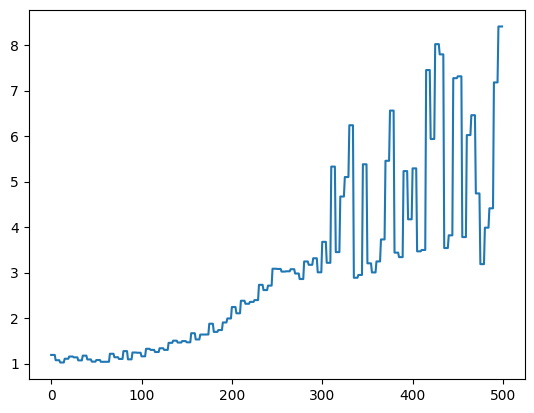

In [85]:
plt.plot(model_PPO.kl_div)
plt.show()

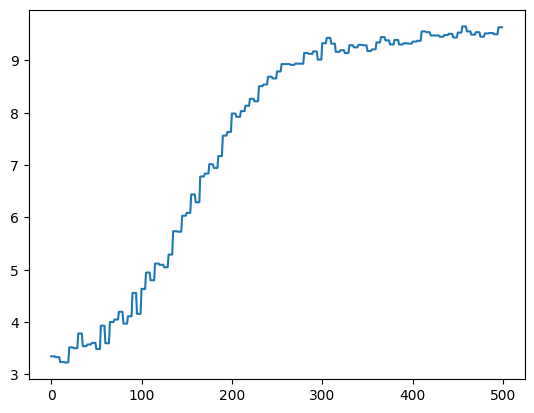

In [86]:
plt.plot(model_PPO.rewards)
plt.show()

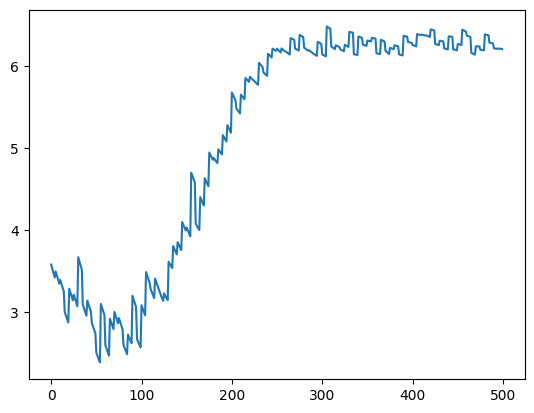

In [87]:
plt.plot(model_PPO.value_losses)
plt.show()

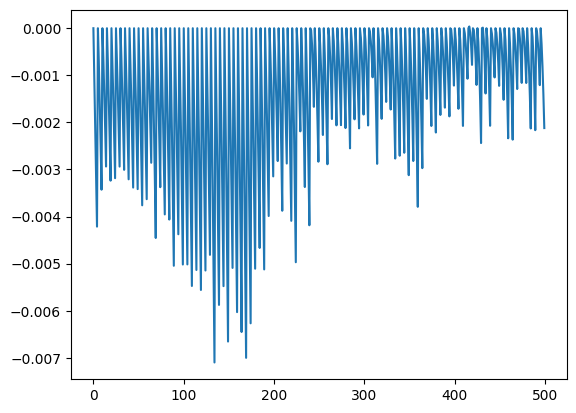

In [88]:
plt.plot(model_PPO.pg_losses)
plt.show()

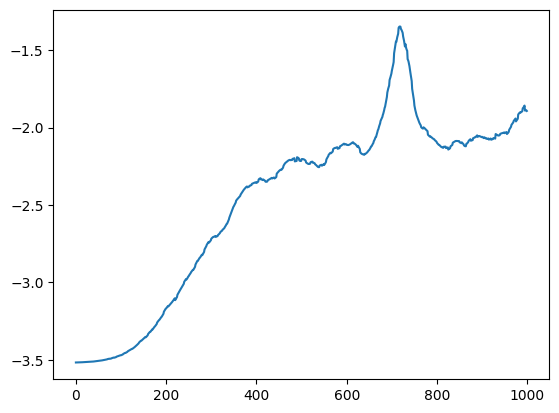

In [37]:
plt.plot(model_PPO.entropy_losses)
plt.show()